In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index
from scipy.stats import ks_2samp, pearsonr, zscore

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

### Load necessary tracking data

In [32]:
# array of years
#years = np.arange( 1983, 2008 )
years = np.arange( 2000, 2005 )

# create list of file names
#file_years = file_concatenator_ERAI(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")

tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]

In [34]:
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERA = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERA = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_indx]
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_indx]

### Plot the instantaneous and lifetime minimum cloud-top temperature stratified by extent

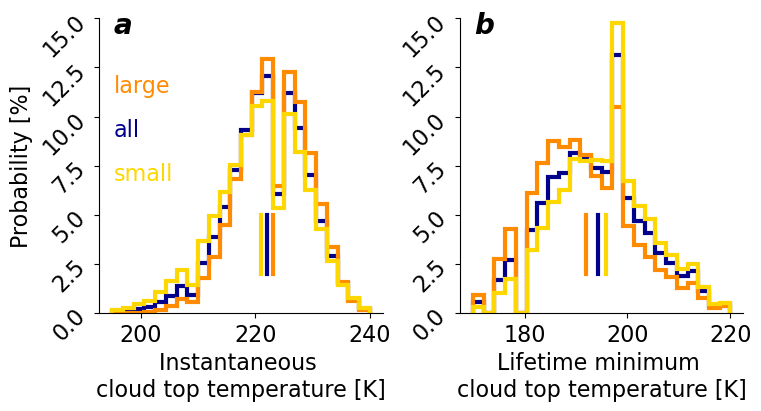

In [35]:
fig, ax = plt.subplots( nrows=1, ncols=2, figsize =(7.5, 4), constrained_layout=True )
nbin=25
lw=3
fs=16

ax[0].hist( ctt_ERA,lw=lw,weights=np.ones_like( ctt_ERA )/ float(len( ctt_ERA ))*100,color='darkblue',bins=np.linspace(195,240,nbin),histtype='step' )
ax[0].plot( [np.nanmean(ctt_ERA), np.nanmean(ctt_ERA)],[2,5],lw=lw,color='darkblue' )

ctt_large = ctt_ERA[rad_ERA>=np.percentile(rad_ERA,75)]
wgts = np.ones_like( ctt_large )/float(len( ctt_large ))*100
ax[0].hist( ctt_large,lw=lw,weights=wgts,color='darkorange',bins=np.linspace(195,240,nbin),histtype='step' )
ax[0].plot( [np.nanmean(ctt_large), np.nanmean(ctt_large)],[2,5],lw=lw,color='darkorange' )
ax[0].set_xlabel( 'Instantaneous '+
                 '\n'+ 'cloud top temperature [K]', fontsize=fs )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].text( 0.05, 0.95, 'a', weight='bold', fontsize=fs+4, style='italic', transform=ax[0].transAxes )
ax[0].text( 0.05, 0.75, 'large', color='darkorange', fontsize=fs, transform=ax[0].transAxes )
ax[0].text( 0.05, 0.6, 'all', color='darkblue', fontsize=fs, transform=ax[0].transAxes )
ax[0].text( 0.05, 0.45, 'small', color='gold', fontsize=fs, transform=ax[0].transAxes )

ctt_small = ctt_ERA[rad_ERA<=np.percentile(rad_ERA,25)]
wgts = np.ones_like( ctt_small )/float(len(ctt_small))*100
ax[0].hist( ctt_small,lw=lw,weights=wgts,color='gold',bins=np.linspace(195,240,nbin),histtype='step' )
ax[0].plot( [np.nanmean(ctt_small), np.nanmean(ctt_small)],[2,5],lw=lw,color='gold' )


ax[1].hist( minctt_ERA,lw=lw,weights=np.ones_like( minctt_ERA )/ float(len( minctt_ERA ))*100,color='darkblue',bins=np.linspace(170,220,nbin),histtype='step' )
ax[1].plot( [np.nanmean(minctt_ERA), np.nanmean(minctt_ERA)],[2,5],lw=lw,color='darkblue' )

minctt_large = minctt_ERA[rad_ERA>=np.percentile(rad_ERA,75)]
wgts = np.ones_like( minctt_large )/float(len( minctt_large ))*100
ax[1].hist(minctt_large,weights=wgts,lw=lw,color='darkorange',bins=np.linspace(170,220,nbin),histtype='step')
ax[1].plot( [np.nanmean(minctt_large), np.nanmean(minctt_large)],[2,5],lw=lw,color='darkorange' )

minctt_small = minctt_ERA[rad_ERA<=np.percentile(rad_ERA,25)]
wgts = np.ones_like( minctt_small )/float(len( minctt_small ))*100
ax[1].hist(minctt_small,lw=lw,weights=wgts,color='gold',bins=np.linspace(170,220,nbin),histtype='step')
ax[1].plot( [np.nanmean(minctt_small), np.nanmean(minctt_small)],[2,5],lw=lw,color='gold' )

ax[1].set_xlabel( 'Lifetime minimum '+
                 '\n'+ 'cloud top temperature [K]', fontsize=fs )
ax[1].text( 0.05, 0.95, 'b', weight='bold', fontsize=fs+4, style='italic', transform=ax[1].transAxes )

for a in ax.flatten():
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylim([0,15])

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/minctt-ctt.pdf', bbox_inches='tight' )
plt.show()

In [36]:
# Calculate statistical significance of these shifts
statistic, p_value = ks_2samp( ctt_large, ctt_small )
print( statistic, p_value )

0.12529693883845683 2.8892333833001265e-301


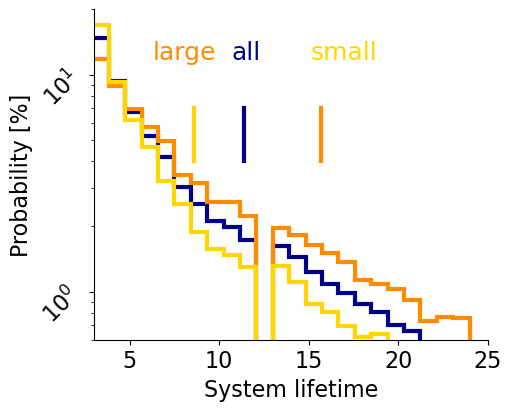

In [37]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize =(5, 4), constrained_layout=True )
nbin=25
lw=3
fs=16

ax.hist( lifetime_ERA,lw=lw,weights=np.ones_like( lifetime_ERA )/ float(len( lifetime_ERA ))*100,color='darkblue',bins=np.linspace(2,24,nbin),histtype='step' )
ax.plot( [np.nanmean(lifetime_ERA), np.nanmean(lifetime_ERA)],[4,7],lw=lw,color='darkblue' )

lifetime_large = lifetime_ERA[rad_ERA>=np.percentile(rad_ERA,75)]
wgts = np.ones_like( lifetime_large )/float(len( lifetime_large ))*100
ax.hist( lifetime_large,lw=lw,weights=wgts,color='darkorange',bins=np.linspace(2,24,nbin),histtype='step' )
ax.plot( [np.nanmean(lifetime_large), np.nanmean(lifetime_large)],[4,7],lw=lw,color='darkorange' )
ax.set_xlabel( 'System lifetime', fontsize=fs )
ax.set_ylabel( 'Probability [%]', fontsize=fs )
ax.text( 0.15, 0.85, 'large', color='darkorange', fontsize=fs+2, transform=ax.transAxes )
ax.text( 0.35, 0.85, 'all', color='darkblue', fontsize=fs+2, transform=ax.transAxes )
ax.text( 0.55, 0.85, 'small', color='gold', fontsize=fs+2, transform=ax.transAxes )

lifetime_small = lifetime_ERA[rad_ERA<=np.percentile(rad_ERA,25)]
wgts = np.ones_like( lifetime_small )/float(len(lifetime_small))*100
ax.hist( lifetime_small,lw=lw,weights=wgts,color='gold',bins=np.linspace(2,24,nbin),histtype='step' )
ax.plot( [np.nanmean(lifetime_small), np.nanmean(lifetime_small)],[4,7],lw=lw,color='gold' )

ax.tick_params( 'both', labelsize=fs )
ax.tick_params( 'y', rotation=45 )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0.6,20])
ax.set_xlim([3,25])
ax.set_yscale('log')

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/lifetimes-by-extent.pdf', bbox_inches='tight' )
plt.show()

### Plot lower-tropospheric saturation deficit filtered by MCS extent

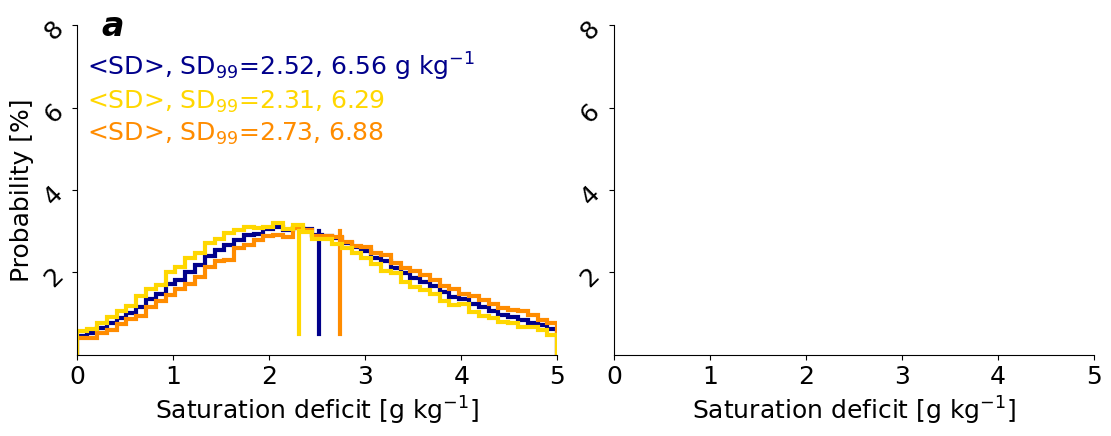

In [15]:
fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(11,4.25), constrained_layout=True )
lw = 3
fs = 18
nbin = 50

wgts = np.ones_like(sd_ERA)/float(len(sd_ERA))*100.
ax[0].hist( sd_ERA, bins=np.linspace(0,5,nbin), weights=wgts, histtype=u'step', lw=lw, color='darkblue' )
ax[0].plot( [np.nanmean(sd_ERA), np.nanmean(sd_ERA)], [0.5,3], lw=lw, color='darkblue' )
upp = np.percentile( rad_ERA, 75 )
wgts = np.ones_like(sd_ERA[rad_ERA >= upp])/float(len(sd_ERA[rad_ERA >= upp]))*100.
ax[0].hist( sd_ERA[rad_ERA >= upp], bins=np.linspace(0,5,nbin), weights=wgts, histtype='step', lw=lw, color='darkorange' )
ax[0].plot( [np.nanmean(sd_ERA[rad_ERA >= upp]), np.nanmean(sd_ERA[rad_ERA >= upp])], [0.5,3], lw=lw, color='darkorange' )
loo = np.percentile( rad_ERA, 25 )
wgts = np.ones_like(sd_ERA[rad_ERA <= loo])/float(len(sd_ERA[rad_ERA <= loo]))*100.
ax[0].hist( sd_ERA[rad_ERA <= loo], bins=np.linspace(0,5,nbin), weights=wgts, histtype='step', lw=lw, color='gold' )
ax[0].plot( [np.nanmean(sd_ERA[rad_ERA <= loo]), np.nanmean(sd_ERA[rad_ERA <= loo])], [0.5,3], lw=lw, color='gold' )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].text( 0.02, 0.85, r"<SD>, SD$_{99}$=" + f"{np.nanmean(sd_ERA):.3}" + ', ' +
           f"{np.nanpercentile(sd_ERA,99):.3}" + r' g kg$^{-1}$', color='darkblue', fontsize=fs, transform=ax[0].transAxes)
ax[0].text( 0.02, 0.75, r"<SD>, SD$_{99}$=" + f"{np.nanmean(sd_ERA[rad_ERA<=loo]):.3}" + ', ' +
           f"{np.nanpercentile(sd_ERA[rad_ERA<=loo],99):.3}" , color='gold', fontsize=fs, transform=ax[0].transAxes)
ax[0].text( 0.02, 0.65, r"<SD>, SD$_{99}$=" + f"{np.nanmean(sd_ERA[rad_ERA>=upp]):.3}" + ', ' +
           f"{np.nanpercentile(sd_ERA[rad_ERA>=upp],99):.3}", color='darkorange', fontsize=fs, transform=ax[0].transAxes)
#ax[0].set_xlim([10**(-3.5),1])
ax[0].text( 0.05, 0.97, 'a', weight='bold', style='italic', fontsize=fs+6, transform=ax[0].transAxes )

#wgts = np.ones_like(pmean_RCE)/float(len(pmean_RCE))*100.
#ax[1].hist( pmean_RCE, bins=np.logspace(-3,2,nbin), weights=wgts, lw=lw, color='darkblue', histtype=u'step' )
#ax[1].plot( [np.nanmean(pmean_RCE), np.nanmean(pmean_RCE)], [6,8], lw=lw, color='darkblue' )
#upp = np.percentile( rad_RCE, 75 )
#wgts = np.ones_like(pmean_RCE[rad_RCE >= upp])/float(len(pmean_RCE[rad_RCE >= upp]))*100.
#ax[1].hist( pmean_RCE[rad_RCE >= upp], bins=np.logspace(-3,2,nbin), lw=lw, color='darkorange', weights=wgts, histtype='step' )
#ax[1].plot( [np.nanmean(pmean_RCE[rad_RCE >= upp]), np.nanmean(pmean_RCE[rad_RCE >= upp])], [6,8], lw=lw, color='darkorange' )
#loo = np.percentile( rad_RCE, 25 )
#wgts = np.ones_like(pmean_RCE[rad_RCE <= loo])/float(len(pmean_RCE[rad_RCE <= loo]))*100.
#ax[1].hist( pmean_RCE[rad_RCE <= loo], bins=np.logspace(-3,2,nbin), weights=wgts, histtype='step', lw=lw, color='gold' )
#ax[1].text( 0.05, 0.97, 'b', weight='bold', style='italic', fontsize=fs+6, transform=ax[1].transAxes )
#ax[1].plot( [np.nanmean(pmean_RCE[rad_RCE <= loo]), np.nanmean(pmean_RCE[rad_RCE <= loo])], [6,8], lw=lw, color='gold' )
#ax[1].text( 0.02, 0.85, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE):.3}" + ", " +
#           f"{np.nanpercentile(pmean_RCE,99):.3}" + r' mm h$^{-1}$', color='darkblue', fontsize=fs, transform=ax[1].transAxes)
#ax[1].text( 0.02, 0.75, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE[rad_RCE<=loo]):.3}" + ", "
#           f"{np.nanpercentile(pmean_RCE[rad_RCE<=loo],99):.3}", color='gold', fontsize=fs, transform=ax[1].transAxes)
#ax[1].text( 0.02, 0.65, r"$<\dot{P}>$=" + f"{np.nanmean(pmean_RCE[rad_RCE>=upp]):.3}" + ", "
#           f"{np.nanpercentile(pmean_RCE[rad_RCE>=upp],99):.3}", color='darkorange', fontsize=fs, transform=ax[1].transAxes)
#ax[1].set_xscale( 'log' )

for a in ax:
    a.set_xlim([0,5])
    a.set_xlabel( r'Saturation deficit [g kg$^{-1}$]', fontsize=fs )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params( 'both', labelsize=18 )
    a.tick_params( 'y', rotation=45 )
    #a.set_ylim([0,7])
    a.set_yticks( [2, 4, 6, 8] )
    
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precip-intensity-clustering.pdf', bbox_inches='tight' )
plt.show()